In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [24]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import torch.optim as optim

# Fixed: Added missing __getitem__ method to Dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # This method was missing - crucial for Dataset class
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Add your actual data loading logic here
        # For now, this is a placeholder - you need to implement based on your dataframe structure
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def prepare_data(root_dir, batch_size=32):
    # Fixed: Moved heavy augmentations to only training data
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Fixed: Using standard ImageNet norms
                           std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(root=os.path.join(root_dir, 'train'), transform=train_transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(root_dir, 'test'), transform=test_transform)

    # Fixed: Added num_workers for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader, train_dataset, test_dataset


In [25]:
import torchvision.models as models
import torch.nn as nn # Ensure nn is imported if not already
class ChestXRayModel(nn.Module):
    def __init__(self, num_classes):
        super(ChestXRayModel, self).__init__()

        self.resnet = models.resnet101(pretrained=True)

        # Fixed: Only freeze convolutional layers, allow classifier to train
        for param in self.resnet.parameters():
            param.requires_grad = False

        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
    def forward(self, x):
        return self.resnet(x)

    def train_model(self, train_loader,val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
        # Fixed: Added device handling and progress tracking
        self.to(device)
        self.train()
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        for epoch in range(num_epochs):
            # ====================
            # TRAIN
            # ====================
            self.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Fixed: Added progress bar and device transfer
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / total
            epoch_acc = 100 * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)

            # ====================
            # VALIDATION
            # ====================
            val_loss, val_acc = self.val_model(val_loader, criterion, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # ====================
        # PLOT
        # ====================
        plt.figure(figsize=(12,5))

        # Loss
        plt.subplot(1,2,1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()

        # Accuracy
        plt.subplot(1,2,2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy over Epochs')
        plt.legend()

        plt.show()

        return train_losses, val_losses, train_accuracies, val_accuracies

    def val_model(self, val_loader, criterion, device='cuda'):
        self.to(device)
        self.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / total
        val_accuracy = 100 * correct / total
        return val_loss, val_accuracy

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/7] | Train Loss: 0.2874, Train Acc: 87.83% | Val Loss: 0.4376, Val Acc: 80.61%
Epoch [2/7] | Train Loss: 0.2064, Train Acc: 91.43% | Val Loss: 0.6242, Val Acc: 72.76%
Epoch [3/7] | Train Loss: 0.1952, Train Acc: 91.70% | Val Loss: 0.5452, Val Acc: 77.72%
Epoch [4/7] | Train Loss: 0.1805, Train Acc: 92.54% | Val Loss: 0.5496, Val Acc: 78.37%
Epoch [5/7] | Train Loss: 0.1714, Train Acc: 93.25% | Val Loss: 0.6461, Val Acc: 74.52%
Epoch [6/7] | Train Loss: 0.1682, Train Acc: 93.31% | Val Loss: 1.1235, Val Acc: 66.19%
Epoch [7/7] | Train Loss: 0.1752, Train Acc: 92.64% | Val Loss: 0.4788, Val Acc: 82.37%


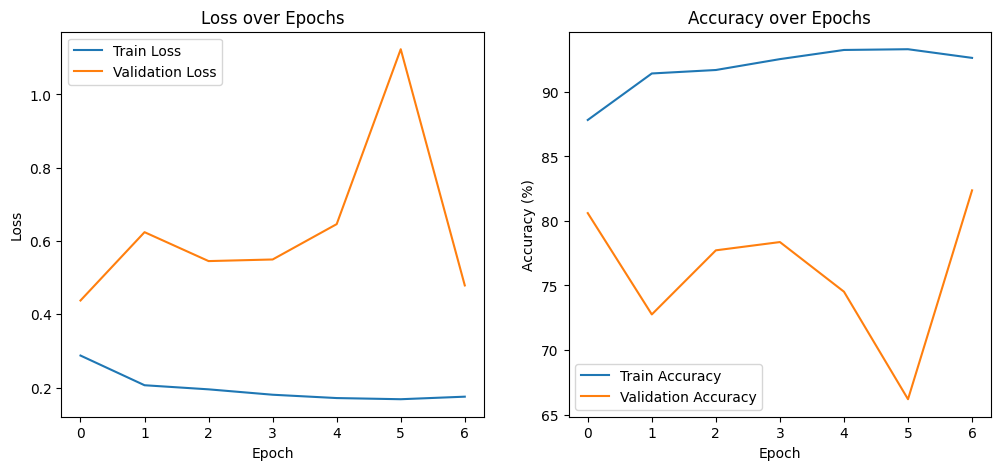

In [26]:
# Example usage:
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, train_dataset, test_dataset = prepare_data('/kaggle/input/chest-xray-pneumonia/chest_xray/', batch_size=32)

    # Create model
    num_classes = len(train_dataset.classes)
    model = ChestXRayModel(num_classes=num_classes)
    model.to(device)


    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.resnet.fc.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=1
    )
    # Train model
    print("Starting training...")
    num_epochs = 7

    train_losses, val_losses, train_accs, val_accs = model.train_model(
    train_loader, val_loader=test_loader, criterion=criterion, optimizer=optimizer, num_epochs=7, device=device
)



        # 6. Validate model
        # ================================
    val_loss, val_accuracy = model.val_model(test_loader, criterion, device=device)

        # ================================
        # 7. Step scheduler based on validation accuracy
        # ================================
    scheduler.step(val_accuracy)


In [28]:
print(f"Final Validation Accuracy: {val_accuracy:.2f}%")


Final Validation Accuracy: 82.37%


In [29]:
# ============================================================
#   EXTRA EVALUATION METRICS (Precision, Recall, F1, CM, ROC)
# ============================================================

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def evaluate_metrics(model, data_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            # Predicted class
            _, preds = torch.max(outputs, 1)

            # Probability for ROC (class 1 only)
            probs = F.softmax(outputs, dim=1)[:, 1]

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # =============================
    # 1. PRECISION - RECALL - F1
    # =============================
    print("\nCLASSIFICATION REPORT:")
    print(classification_report(all_labels, all_preds, target_names=['NORMAL','PNEUMONIA']))

    # =============================
    # 2. CONFUSION MATRIX
    # =============================
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # =============================
    # 3. ROC CURVE + AUC
    # =============================
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print(f"AUC Score: {auc_score:.4f}")


Extra Metrics Evaluation...

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      NORMAL       0.91      0.59      0.72       234
   PNEUMONIA       0.80      0.96      0.87       390

    accuracy                           0.82       624
   macro avg       0.85      0.78      0.79       624
weighted avg       0.84      0.82      0.81       624



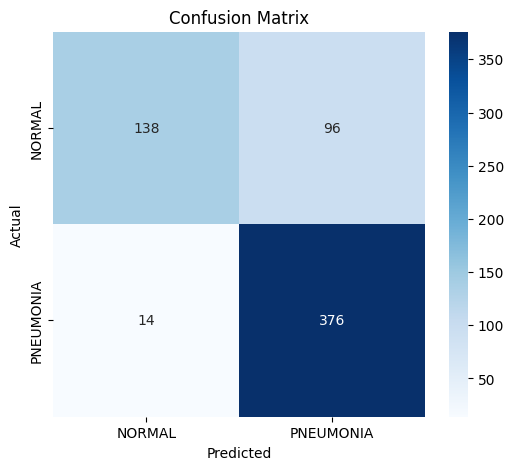

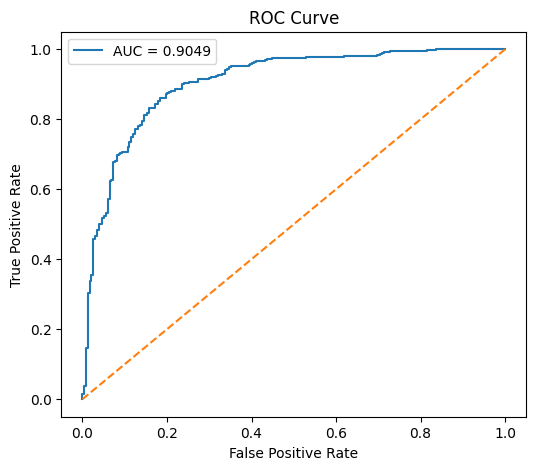

AUC Score: 0.9049


In [31]:
print("Extra Metrics Evaluation...")
evaluate_metrics(model, test_loader, device=device)
